In [321]:
library(TSclust)

Loading required package: pdc
Loading required package: cluster


In [4]:
install.packages('lars', repos='https://cran.r-project.org/')

Installing package into 'C:/Users/Tom Work/Documents/R/win-library/3.3'
(as 'lib' is unspecified)


package 'lars' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Tom Work\AppData\Local\Temp\Rtmpkfn4nW\downloaded_packages


In [6]:
source("C:/Users/Tom Work/PycharmProjects/twipsy-lite/ts.R")

In [5]:
library(lars)

Reference: http://www.stat.cmu.edu/~arinaldo/papers/arLasso.pdf

Lars documentation: https://cran.r-project.org/web/packages/lars/lars.pdf

In [9]:
junets = june()
septts = sept()

 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1]   2   3   4   5   6   7  26  27  28  29  30  31 721 722 723
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725
 [1] 408 409 410 411 412 413 414 415 476 477 478 479 485 486 721 722 723 724 725


Transform series to make stationary

In [149]:
# difference by week, log
stationary <- function(ts){
    return (diff(log(ts),  168))
    }

In [150]:
st_j = stationary(junets)
st_s = stationary(septts)

Series without anomaly weeks:

In [218]:
s_short = st_s[(168+1):(168*3)]
j_short = st_j[1:(168*2)]

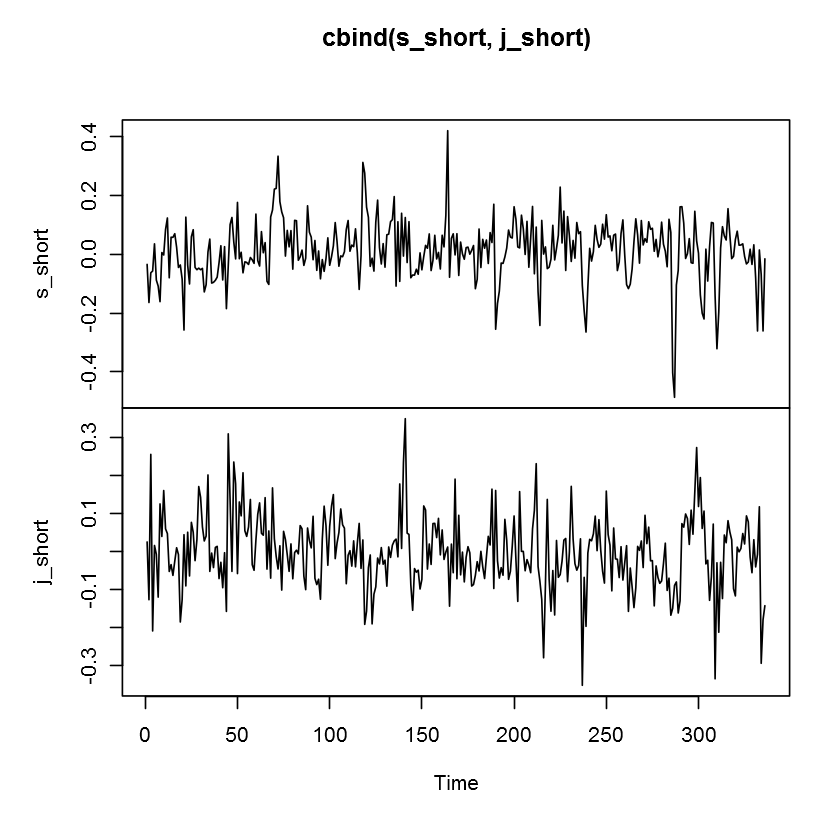

In [219]:
plot.ts(cbind(s_short, j_short))

Stationary series over month

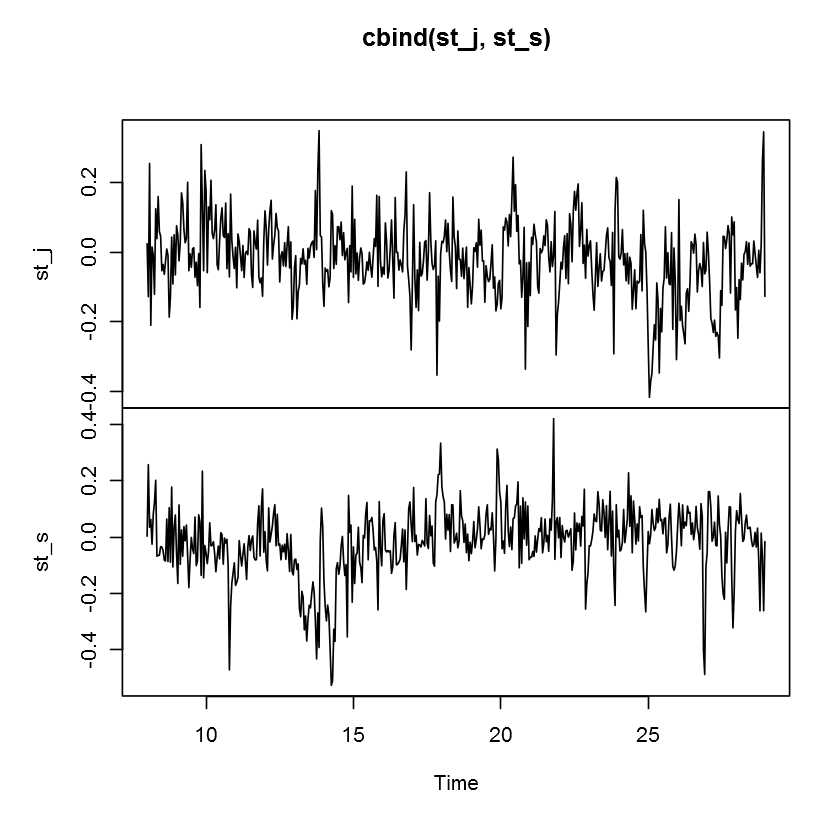

In [151]:
plot.ts(cbind(st_j, st_s))

Breakdown by week:

In [300]:
j.1 = as.numeric(window(st_j, start=c(8, 1), end=c(14, 24)))
j.2 = as.numeric(window(st_j, start=c(15, 1), end=c(21, 24)))
j.3 = as.numeric(window(st_j, start=c(22, 1), end=c(28, 24)))
s.1 = as.numeric(window(st_s, start=c(8, 1), end=c(14, 24)))
s.2 = as.numeric(window(st_s, start=c(15, 1), end=c(21, 24)))
s.3 = as.numeric(window(st_s, start=c(22, 1), end=c(28, 24)))

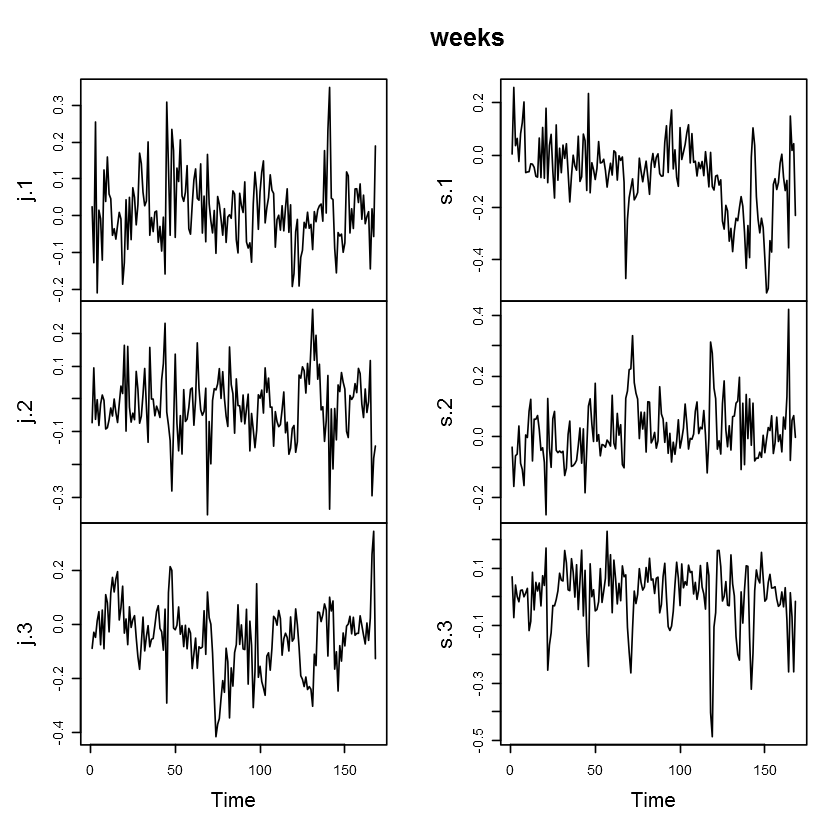

In [301]:
weeks = cbind(j.1, j.2, j.3, s.1, s.2, s.3)
plot.ts(weeks)

PACF by week

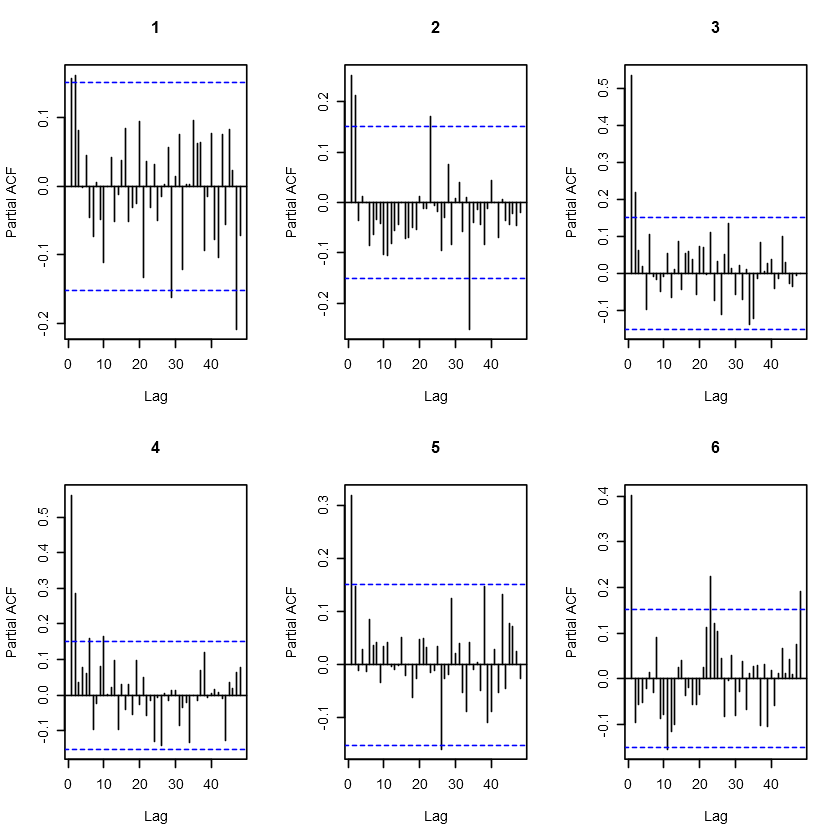

In [360]:
par(mfrow=c(2, 3))
for (i in 1:6){
    
    pacf(weeks[,i], lag.max=48, main=i)
}

# Lasso regression

Set number of lags

In [422]:
p=25

Break time series into a bunch of explanatory variables

In [306]:
ar_matrix <- function(ts, lags){
    m = matrix(ncol=lags, nrow=(length(ts)-lags))
    for (i in 1:nrow(m)){
        m[i, ] = ts[i:(i+lags-1)]
    }
    return (m)
}

In [423]:
ar_s = ar_matrix(s_short, p)

In [424]:
ar_j = ar_matrix(j_short, p)

Confirm that it works...

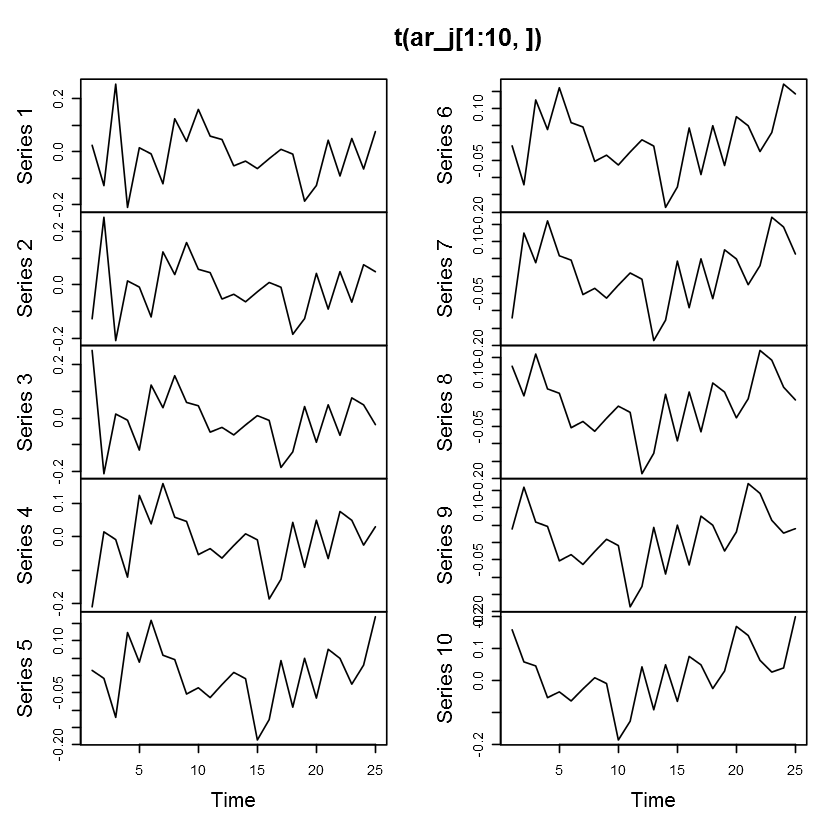

In [425]:
plot.ts(t(ar_j[1:10,]))

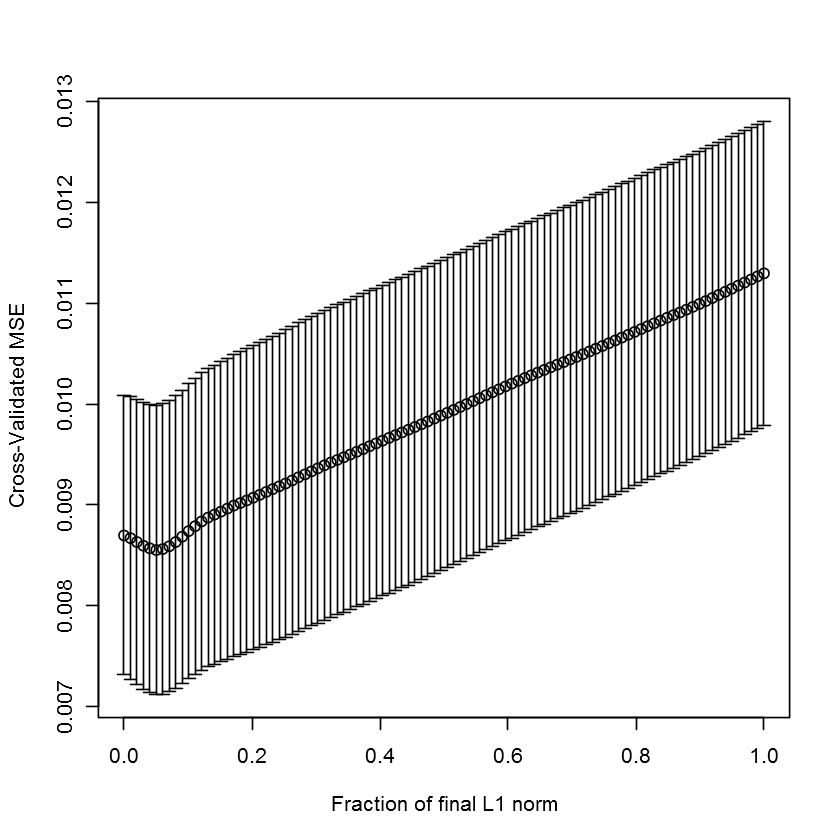

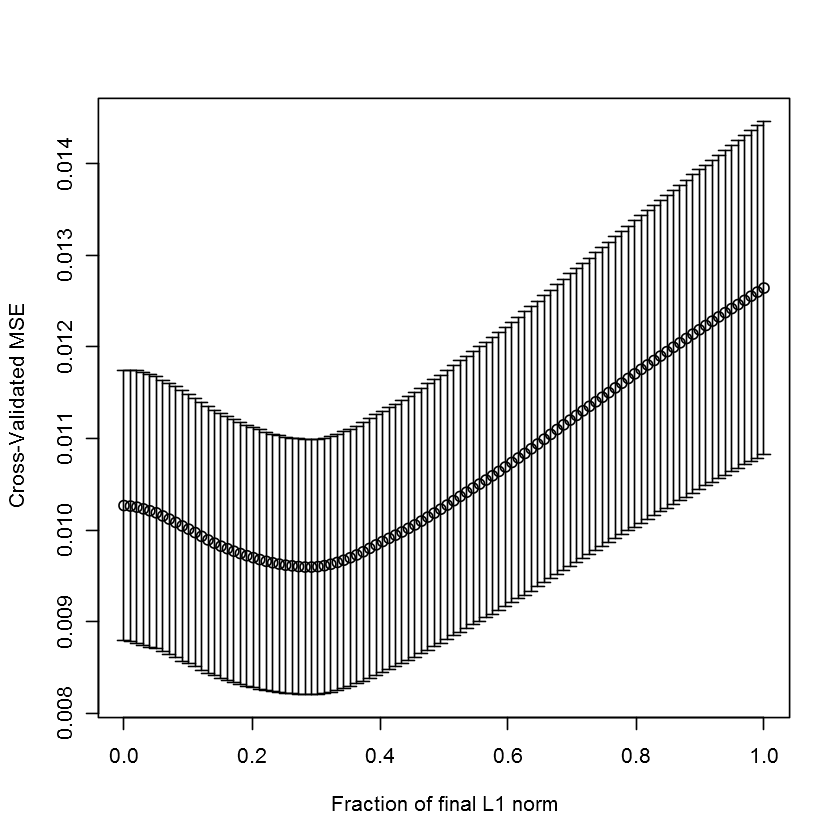

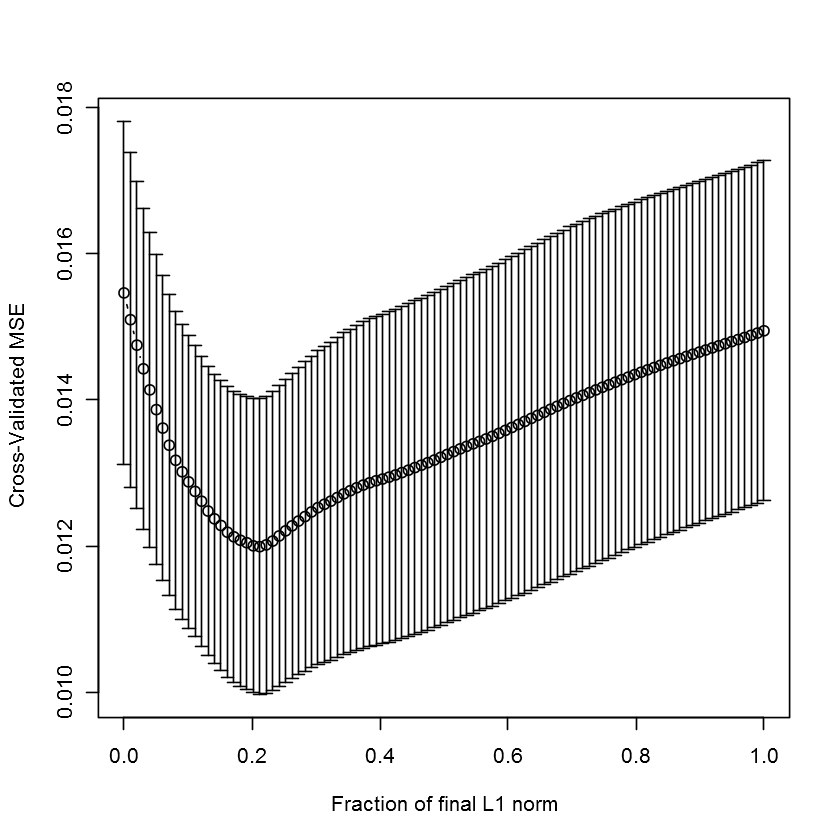

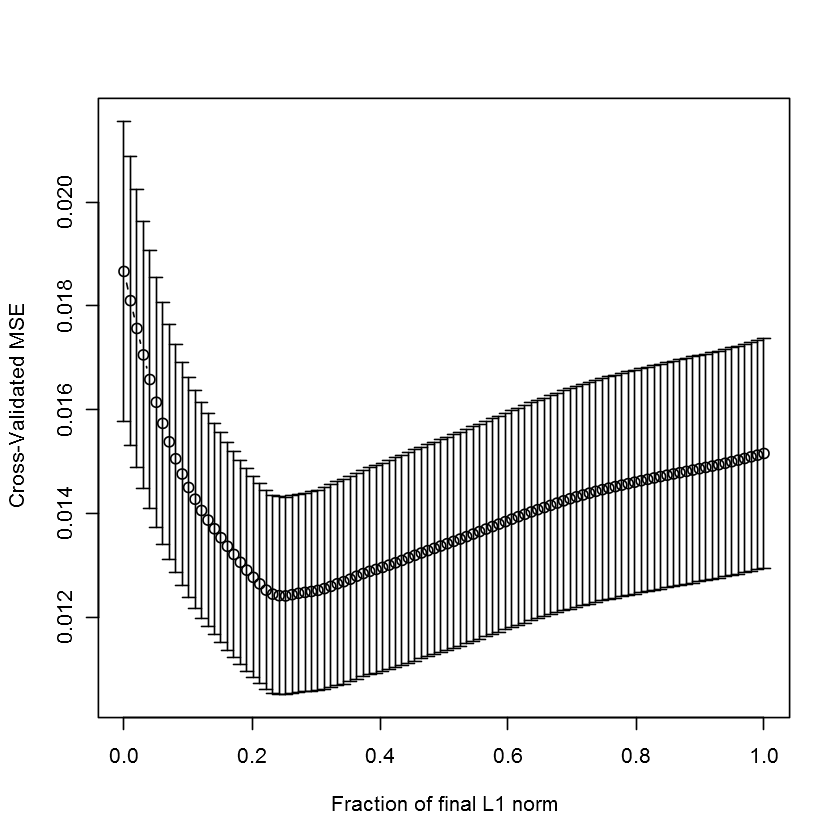

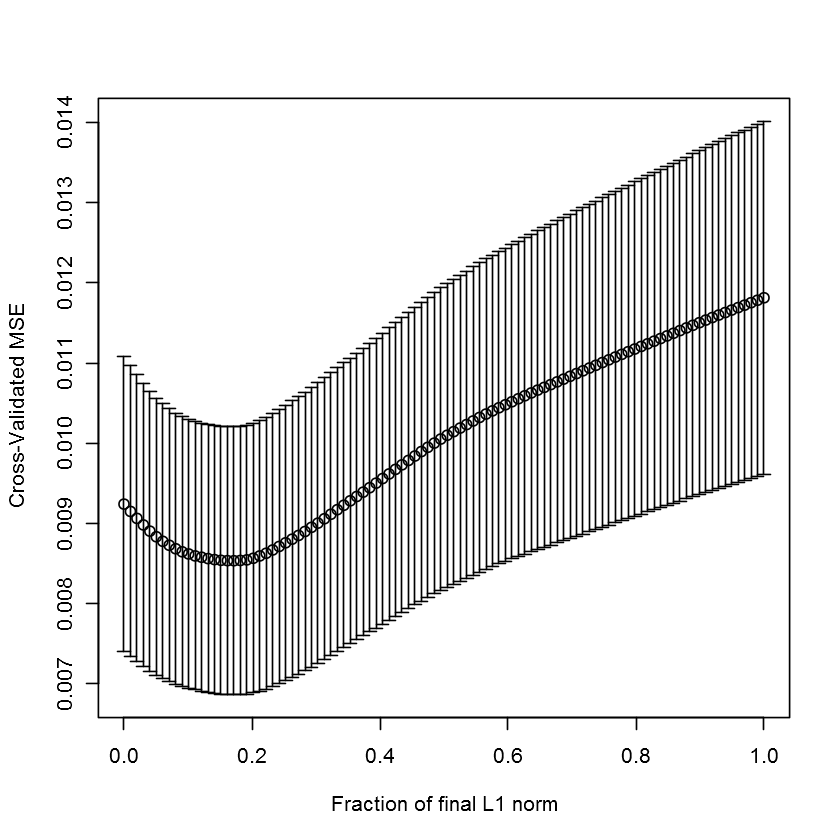

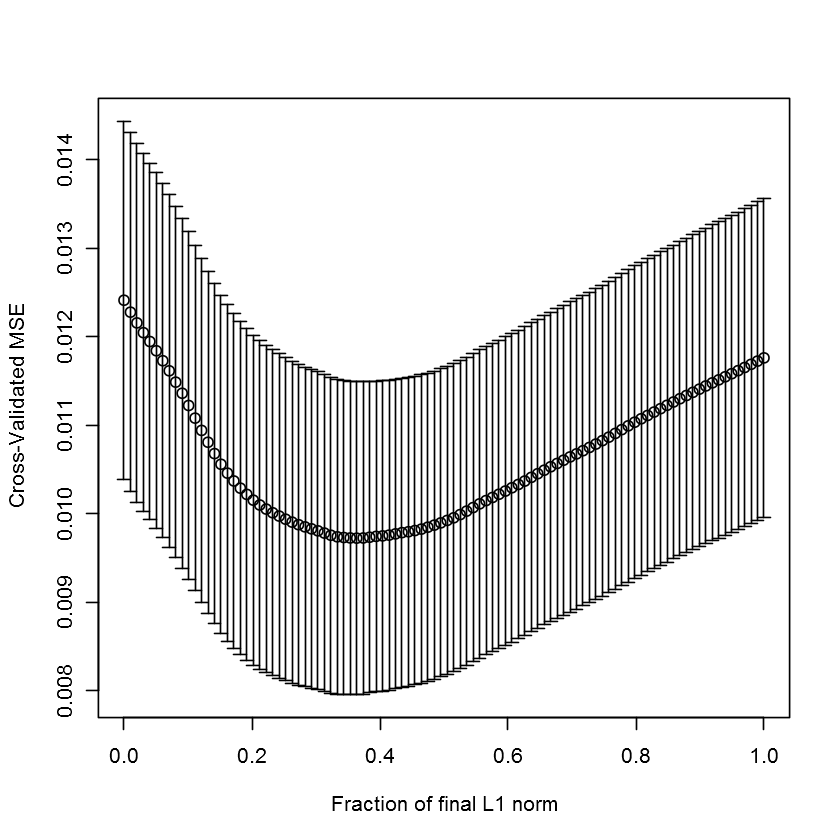

In [453]:
# matrix of regression parameters
mreg = matrix(nrow=p, ncol=6)
for (i in 1:6){
    # create regression matrix matrix
    arm = ar_matrix(weeks[,i], p)
    
    # get regression coefficient (s= number of steps in lars i.e. number of coefficients in ar model)
    reg = lars(arm, weeks[(p+1):length(s.1),i], normalize=FALSE)
    mreg[,i] = predict.lars(reg, s=5, type='coefficients', mode='step')$coefficients
#     mreg[,i] = predict.lars(reg, s=0.2, type='coefficients', mode='fraction')$coefficients
    # plot cross validated mse
    cv.lars(arm, weeks[(p+1):length(s.1), i], K=20)
}

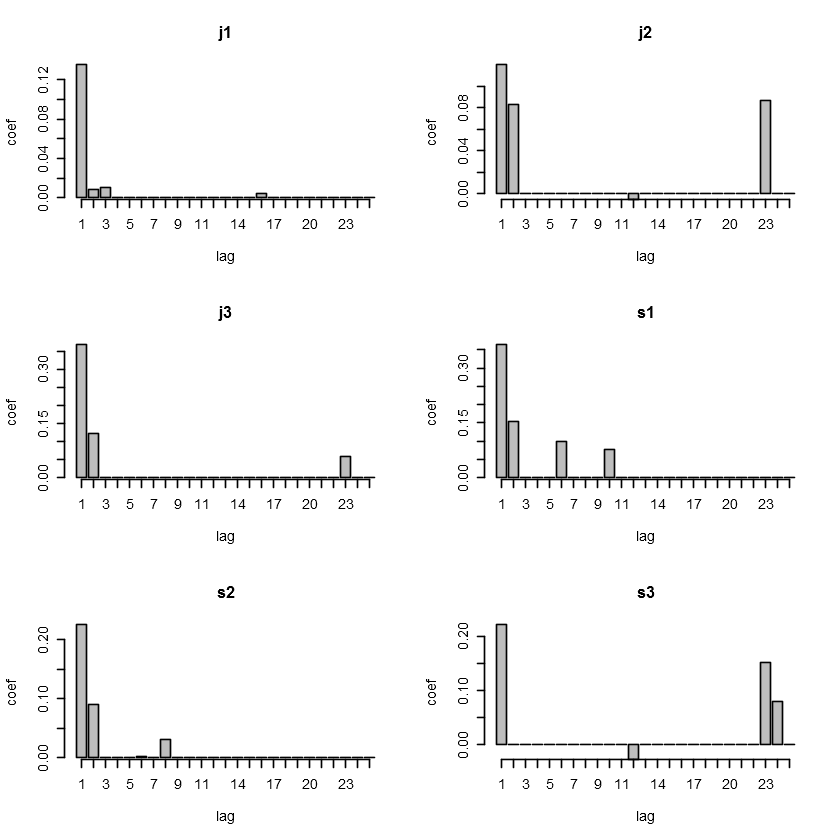

In [469]:
reversed = apply(mreg, 2, rev)
par(mfrow = c(3,2))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    bp=barplot(reversed[,i], xlab='lag', ylab='coef', main=names[i])
    axis(1,at=bp, labels= c(1:25))
    }

# Y-W AR by AIC

In [472]:
mar = matrix(nrow=25, ncol=6)
for (i in 1:6){
    armodel = c(ar(weeks[,i], order.max=25)$ar, rep(0, 25))[1:25]
    mar[,i] = armodel
    }

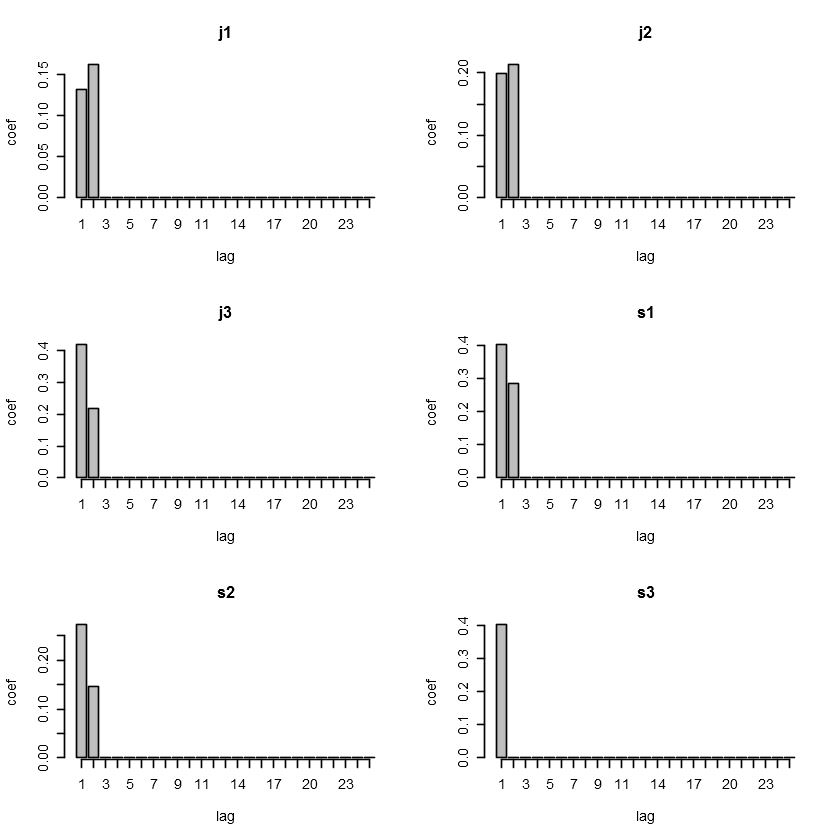

In [473]:
par(mfrow = c(3,2))
names = c('j1', 'j2', 'j3', 's1', 's2', 's3')
for (i in 1:6){
    bp=barplot(mar[,i], xlab='lag', ylab='coef', main=names[i])
    axis(1,at=bp, labels= c(1:25))
    }

l2 between lasso ar coef

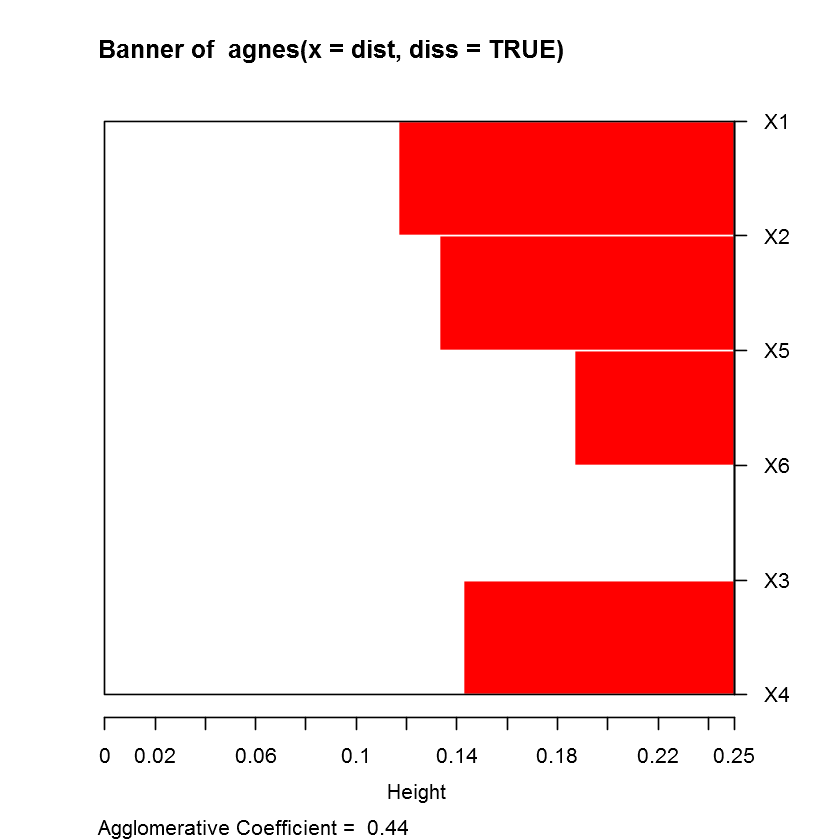

Medoids:
     ID      
[1,] "2" "X2"
[2,] "4" "X4"
Clustering vector:
X1 X2 X3 X4 X5 X6 
 1  1  2  2  1  1 
Objective function:
     build       swap 
0.10121832 0.09458177 

Available components:
[1] "medoids"    "id.med"     "clustering" "objective"  "isolation" 
[6] "clusinfo"   "silinfo"    "diss"       "call"      

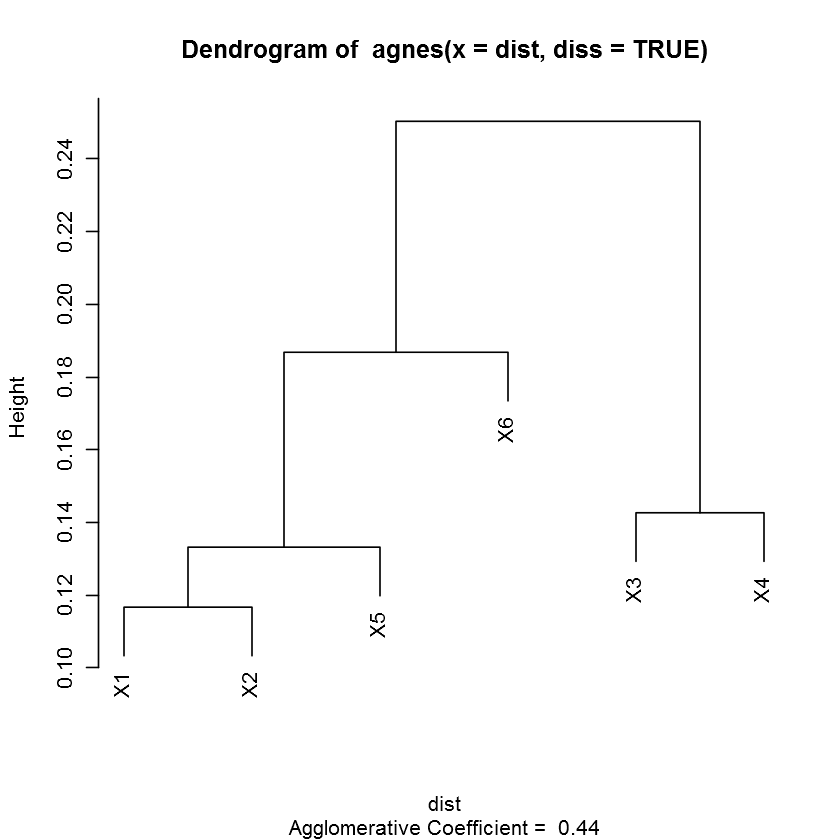

In [474]:
dist = diss(data.frame(mreg), METHOD='EUCL')
plot(agnes(dist, diss=TRUE))
pam(dist, 2, diss=TRUE)

l2 dist between y-w aic ar

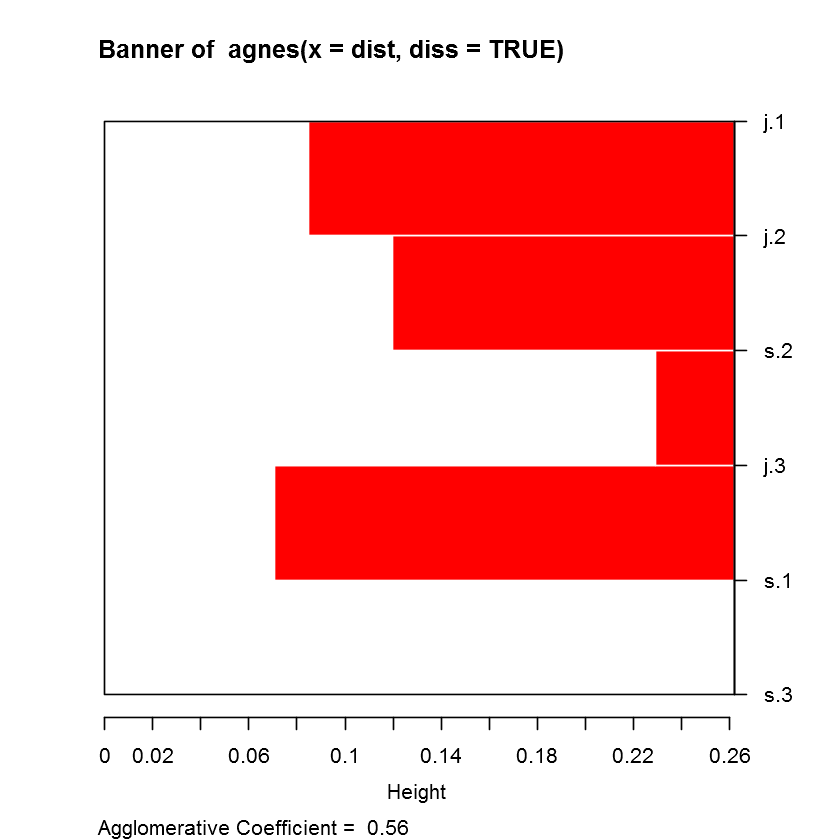

Medoids:
     ID       
[1,] "5" "s.2"
[2,] "4" "s.1"
Clustering vector:
j.1 j.2 j.3 s.1 s.2 s.3 
  1   1   2   2   1   1 
Objective function:
     build       swap 
0.08445004 0.08445004 

Available components:
[1] "medoids"    "id.med"     "clustering" "objective"  "isolation" 
[6] "clusinfo"   "silinfo"    "diss"       "call"      

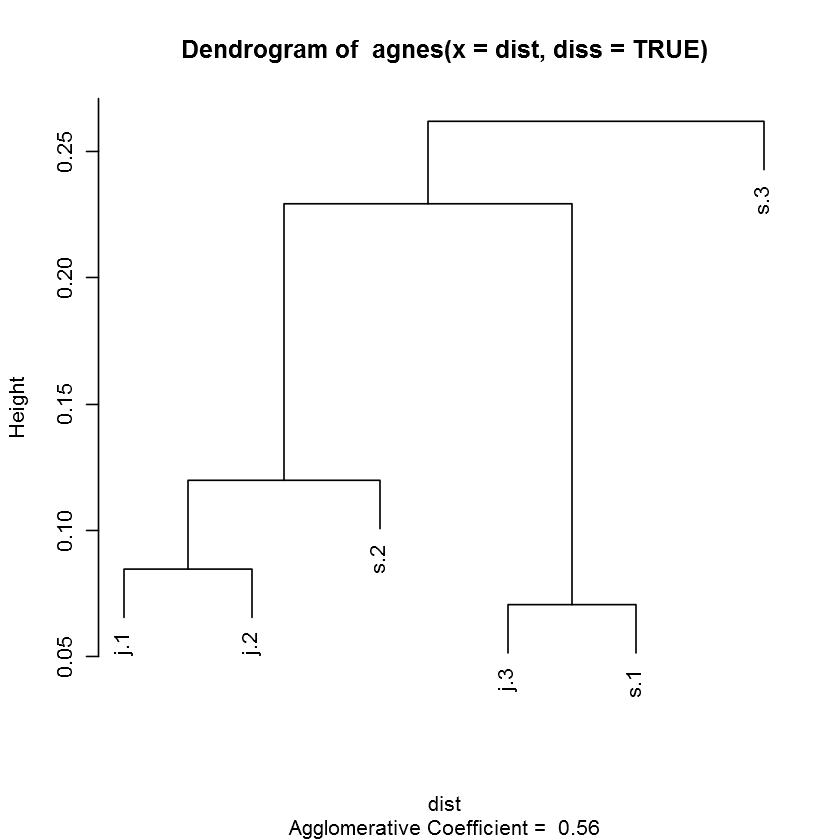

In [476]:
dist = diss(data.frame(weeks), METHOD='AR.PIC')
plot(agnes(dist, diss=TRUE))
pam(dist, 2, diss=TRUE)

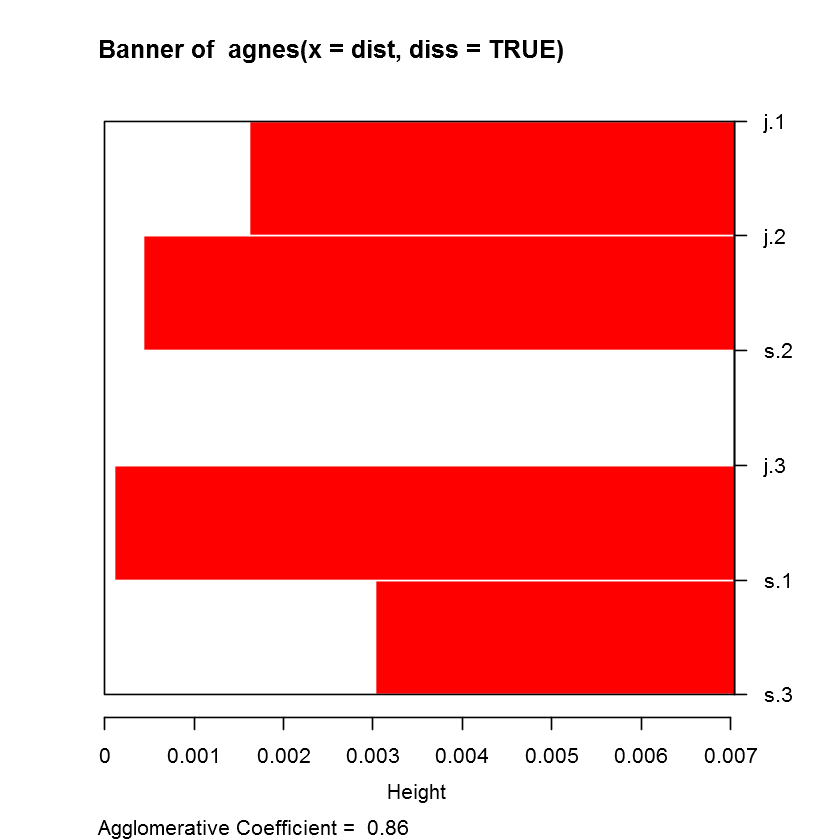

Medoids:
     ID       
[1,] "5" "s.2"
[2,] "4" "s.1"
Clustering vector:
j.1 j.2 j.3 s.1 s.2 s.3 
  1   1   2   2   1   1 
Objective function:
       build         swap 
0.0006784453 0.0006784453 

Available components:
[1] "medoids"    "id.med"     "clustering" "objective"  "isolation" 
[6] "clusinfo"   "silinfo"    "diss"       "call"      

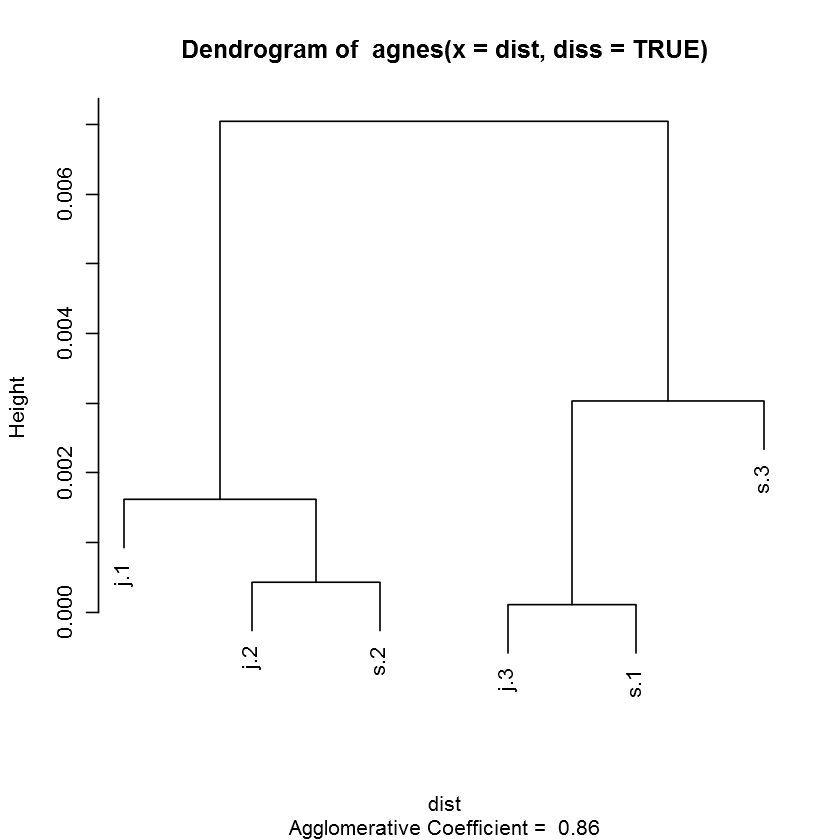

In [483]:
dist = diss(data.frame(weeks), METHOD='PACF', lag.max=25, p=0.9)
plot(agnes(dist, diss=TRUE))
pam(dist, 2, diss=TRUE)